In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
starting_exp = 4180
ending_exp = 4188
save_processed_data = True
exp_lists_preformatted = [
    '4000_4017.csv', '4018_4035.csv', '5000_5017.csv', '5018_5035.csv', '6000_6017.csv', '6018_6035.csv', # DQN
    '4036_4053.csv', '4054_4071.csv', '5036_5053.csv', '5054_5071.csv', '6036_6053.csv', '6054_6071.csv', # REINFORCE
    '4072_4089.csv', '4090_4107.csv', '5072_5089.csv', '5090_5107.csv', '6072_6089.csv', '6090_6107.csv', # CMA
    '4108_4125.csv', '4126_4143.csv', '5108_5125.csv', '5126_5143.csv', '6108_6125.csv', '6126_6143.csv', # ODT 1
    '4144_4161.csv', '4162_4179.csv', '5144_5161.csv', '5162_5179.csv', '6144_6161.csv', '6162_6179.csv' # ODT 2
] # Existing formatted datasets
#exp_lists_preformatted = ['4000_4000.csv', '4036_4036.csv']
#exp_lists_preformatted = ['4000_4017.csv', '4018_4035.csv', '4036_4053.csv', '4054_4071.csv']
#exp_lists_preformatted = []

# TODO: REMOVE THIS!!
index = 1
starting_exp = int(exp_lists_preformatted[index].split("_")[0])
ending_exp = int(exp_lists_preformatted[index].split("_")[1].split('.')[0])

exp_lists_preformatted = []

print(f"Running for experiments {starting_exp} to {ending_exp}")

Running for experiments 4018 to 4035


In [4]:
target_agg_count = 10
target_reward_type = 'greedy'

exp_agent_data = []

experiments = range(starting_exp, ending_exp + 1)

# REMOVE THIS
#algos = ['DQN', 'PPO', 'CMA', 'ODT']
#route_types = ['per-car', 'per-zone']

if len(exp_lists_preformatted) == 0:
    for ind, exp_num in enumerate(experiments):
        config_fname = f'./Exp_{exp_num}/config.yaml'
        
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        eval_c = c['eval_config']
        cma_c = c['cma_parameters']
    
        if federated_c['aggregation_count'] != target_agg_count:
            print(f"Experiment {exp_num} does not have matching aggregation level")
            continue

        rtype = 'communal' if nn_c['average_rewards_when_training'] else 'greedy'

        if rtype != target_reward_type:
            print(f"Experiment {exp_num} does not have matching reward type")
            continue
        
        ev_info = []
    
        seed = env_c['seed']
    
        algorithm_dm = algo_c['algorithm']
        
        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None  # Handle the error and return None or an empty object
        
        
        d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
        
        if not os.path.exists(d_base):
            d_base = f"../metrics/Exp_{exp_num}"
                
        base_path = f"{d_base}/train/metrics"
    
        print(f'Loading {base_path}_agent_metrics.csv')
        agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
        
        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        
        agent_data['algorithm'] = algorithm_dm
        #agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
        agent_data['route_type'] = 'per-zone' if algo_c['agent_by_zone'] else 'per-car'
        #agent_data['route_type'] = route_types[ind % len(route_types)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
        
        agent_data['season'] = env_c['season']    
        agent_data['num_aggs'] = federated_c['aggregation_count']    
        agent_data['eps_per_agg'] = cma_c['max_generations'] if algorithm_dm == 'CMA' else nn_c['num_episodes']
    
        exp_agent_data.append(agent_data)

Experiment 4018 does not have matching aggregation level
Experiment 4019 does not have matching aggregation level
Experiment 4020 does not have matching aggregation level
Loading ../../../../storage_1/metrics/Exp_4021/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4022/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4023/train/metrics_agent_metrics.csv
Experiment 4024 does not have matching aggregation level
Experiment 4025 does not have matching aggregation level
Experiment 4026 does not have matching aggregation level
Experiment 4027 does not have matching aggregation level
Experiment 4028 does not have matching aggregation level
Experiment 4029 does not have matching aggregation level
Loading ../../../../storage_1/metrics/Exp_4030/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4031/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4032/train/metrics_agent_metrics.csv
Experiment 40

In [5]:
if len(exp_lists_preformatted) == 0:

    # Convert data to DataFrame for easier manipulation
    df_agent = pd.concat(exp_agent_data, ignore_index=True)
    
    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'route_type', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    
    # Rename the 'reward' column to 'cumulative_reward' for clarity
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    
    # Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
    cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    
    cumulative_agent_df.head()

In [6]:
# Define the file path with starting_exp and ending_exp variables
file_path_for_processed_data = f'../../../../storage_1/metrics/formatted_experiment_data/part_3'

if len(exp_lists_preformatted) == 0:

    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'route_type'])['cumulative_reward']
        .mean()
        .reset_index()
    )
    
    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['algorithm', 'seed', 'route_type', 'episode']
    )
    
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'route_type'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )

    if save_processed_data:
        if not os.path.exists(file_path_for_processed_data):
            os.makedirs(file_path_for_processed_data)
        
        # Save the DataFrame to a CSV file
        cumulative_avg_reward_by_algorithm.to_csv(f"{file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv", index=False)
        
        print(f"Data successfully saved to {file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv")

if len(exp_lists_preformatted) > 0:
    dataframes = []
    
    # Load and combine datasets
    for existing_set in exp_lists_preformatted:
        loaded_dataset = pd.read_csv(f"{file_path_for_processed_data}/{existing_set}")
        # Combine datasets
        dataframes.append(loaded_dataset)

    cumulative_avg_reward_by_algorithm = pd.concat(dataframes, ignore_index=True)

Data successfully saved to ../../../../storage_1/metrics/formatted_experiment_data/part_3/4018_4035.csv


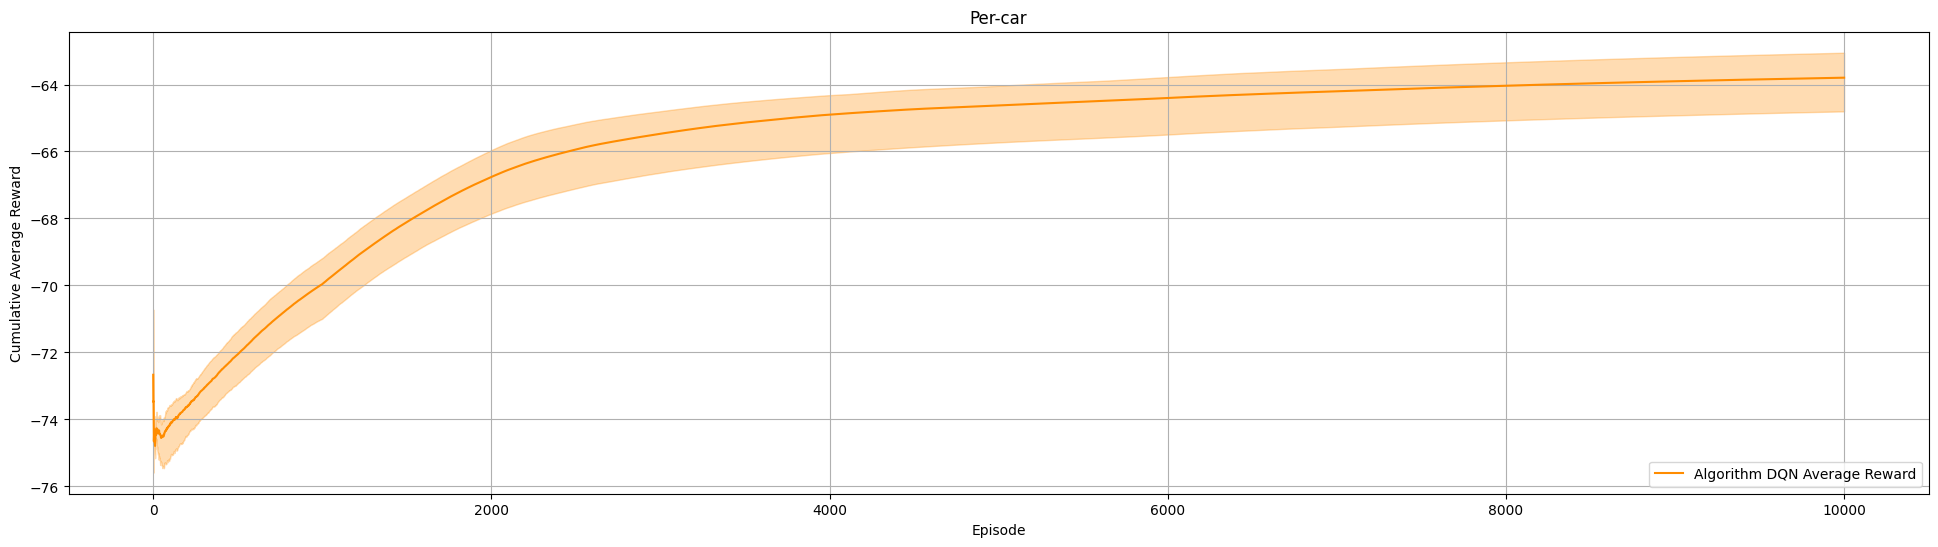

In [7]:
num_plots = len(cumulative_avg_reward_by_algorithm['route_type'].unique())

fig, axes = plt.subplots(1, num_plots, figsize=(24, 6))  # Adjust figsize as needed

axes = np.atleast_1d(axes)

for plot_ind, route_type in enumerate(cumulative_avg_reward_by_algorithm['route_type'].unique()):
    ax = axes[plot_ind]
    
    route_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['route_type'] == route_type]
        
    for algo in route_type_data['algorithm'].unique():
        
        # Filter the data for the current zone
        algo_data = route_type_data[route_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        algo_name = algo
        if algo_name == 'CMA':
            algo_name = 'CMA-ES'
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f'Algorithm {algo_name} Average Reward'
        )
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title('Per-zone' if route_type == 'per-zone' else 'Per-car')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()

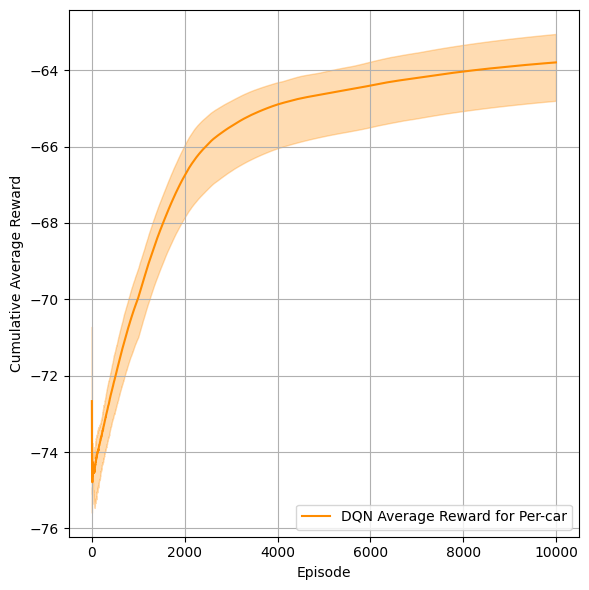

In [8]:
num_plots = len(cumulative_avg_reward_by_algorithm['route_type'].unique())

fig, axes = plt.subplots(num_plots, 1, figsize=(6, 6), sharey=True, sharex=True)  # Adjust figsize as needed

axes = np.atleast_1d(axes)

for plot_ind, route_type in enumerate(cumulative_avg_reward_by_algorithm['route_type'].unique()):
    ax = axes[plot_ind]
    
    route_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['route_type'] == route_type]
        
    for algo in route_type_data['algorithm'].unique():
        # Filter the data for the current zone
        algo_data = route_type_data[route_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        algo_name = algo
        if algo_name == 'CMA':
            algo_name = 'CMA-ES'
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f"{algo_name} Avg. Reward for {'Per-zone' if route_type == 'per-zone' else 'Per-car'}"
        )
    
    axes[-1].set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    #ax.set_title('Per-zone' if route_type == 'per-zone' else 'Per-car')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.tight_layout()

plt.savefig('./Figures/per_car_vs_zone.png', dpi=300, bbox_inches='tight')

fig.show()